# Predicting Inland Empire Warehouse Growth

### UDS Final Project -  Lucy Briggs, Carolyn Pugh, Monisha Reginald, Alyssa Suzukawa

### Research Question:
#### If warehouses continue growing at the same rate in Southern California, what will the region look like by the year 2030?
Warehouses have been rapidly expanding in the Inland Empire, and have significant environmental justice implications. We wanted to understand where, based on trends from 2010-2020, future warehouses might be built in San Bernardino and Riverside, California. To do this, we collected data that might be related to warehouse siting, such as land values, existing warehouse locations, distance to major roadways, and local demographics. We then used machine learning to train models for predicting the probability that a warehouse will be built on a land parcel by 2030. 

### Overview of Notebook:
Section 1. Data Collection & Cleaning

Section 2. Random Forest Models

Section 3. Neural Network Models

Section 4. Discussion of Results


## Data Collection & Cleaning

#### Assessor Parcel Data
[Initial Data Cleaning for Riverside Parcel Data](https://github.com/monishareginald/uds-warehouse-project/blob/main/riversidegeom.ipynb)<br>
[Data Wrangling Notebook](https://github.com/monishareginald/uds-warehouse-project/blob/main/Assessor%20Parcel%20Data%20Wrangling%20with%20Freight%20and%20Warehouses.ipynb)<br>
Data Sources: Assessor Parcel Data from [Riverside County GIS](https://gis.rivco.org/pages/data-distribution) and [San Bernardino Open Data Portal](https://open.sbcounty.gov/datasets/countywide-parcels/about)<br>
* First, we cleaned the assessor parcel data from Riverside and San Bernardino Counties separately. This process included renaming variables of interest to match and dissolving by APN to aggregate the data to the parcel level. 
* Next, we concatenated the two geodataframes to create a single geodataframe with all of the parcels across the two counties.
* Much of the Inland Empire is rural and unlikely to experience development, so we wanted to focus our analysis on the areas where warehouses have historically been built. To achieve this, we created a "mask" representing the area within 70 miles of the Ontario Airport and then clipped our parcel dataset to that mask. The figures below display how this changed the geographic extent of our analysis.<br><br>
![title](figures/parcel_clipping.PNG) 

#### Warehouse Data (Monisha)
[Data Wrangling Noteboook](https://github.com/monishareginald/uds-warehouse-project/blob/main/Assessor%20Parcel%20Data%20Wrangling%20with%20Freight%20and%20Warehouses.ipynb)<br>
Data Source: [Warehouse CITY data on warehouse APNs and year built](https://radicalresearch.shinyapps.io/WarehouseCITY/)<br>
* First, we created a dataset of warehouses that contained one row per APN. Through exploratory mapping and a review of the counties' Zoning District Maps, we determined that duplicated APNs in the dataset represented parcels with multiple warehouses located within the parcel. We wanted our analysis to take place at the parcel level, so we used groupby to aggregate our data with the appropriate functions (e,g., the minimum "year" to represent the first year that a warehouse was built on the parcel, but the sum of "sqft" to represent the total square footage of all warehouses built within a single parcel.  
* Next, we used a series of lambda functions to create boolean variables that noted whether a parcel had a warehouse on it at the start of 2010, whether the parcel had a warehouse on it at the start of 2020, and whether a warehouse was specifically built during the 2010s (the dependent variable we used to train our machine learning models). 

In [1]:
#Add Alyssa's map of current warehouse locations here

#### Interactive Map of Current Warehouses in Buffer (Alyssa)

This interactive map visualizes where the 3,389 warehouses in the area of study are located. 

**Move the map around!**

In [3]:
# Run code (hidden) below to view interactive map
warehouse_map

#### **Code**: Map of Current Warehouses in Buffer (Alyssa)

In [4]:
# import relevant libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# import data
all_parcels = pd.read_csv('data/join_scag_to_parcels_left_2019.csv',
                          usecols=['APN','lon', 'lat', 'num_warehouses'])
current_warehouses = all_parcels[all_parcels['num_warehouses'] >= 1]

# get geometry
current_warehouses = gpd.GeoDataFrame(current_warehouses, geometry = gpd.points_from_xy(current_warehouses['lon'], current_warehouses['lat'], crs = 'EPSG:4326'))

# calculate a 70 mile buffer around the Ontaria Airport & turn this into a geodataframe
airport=gpd.points_from_xy(x=[6683335.118285051], y=[1843271.4373799062], crs=2229) #2229
buffer=airport.buffer(369600)
buffer=gpd.GeoDataFrame(geometry=buffer,crs=2229)

# match projection to buffer
current_warehouses.to_crs(epsg=2229)

# warehouse map
warehouse_map = current_warehouses.explore(# this defines the field to "choropleth"
        legend=True,
        #cmap='RdYlGn_r', # the "_r" reverses the color
        tiles='CartoDB positron')

#### Distance to Freight Network (Monisha)
[Data Wrangling Noteboook](https://github.com/monishareginald/uds-warehouse-project/blob/main/Assessor%20Parcel%20Data%20Wrangling%20with%20Freight%20and%20Warehouses.ipynb)<br>
Data Source: [Shapefile of National Highway Freight Network from Federal Highway Administration ](https://fpcb.ops.fhwa.dot.gov/tools_nhfn.aspx)<br>
We used the geopandas function sjoin_nearest to calculate the distance between each parcel and the NHFN. The map below displays the results.<br><br>
![title](figures/freight.png)

#### SCAG Data (Alyssa to fill in this section & link to data/prep notebooks) 


#### Census Data  
[Notebook for 2009 Data](https://github.com/monishareginald/uds-warehouse-project/blob/main/Census-2009-final.ipynb)<br>
[Notebook for 2019 Data](https://github.com/monishareginald/uds-warehouse-project/blob/main/Census-2019.ipynb)<br>
Data Source: [American Community Survey (5 year estimates) for 2009 and 2019](https://www.census.gov/programs-surveys.html)<br>
* used cenpy and API to pull variables for race, homeownership, education, income, and occupation
* merged tables and variables for both counties and added census tract geometries

#### Joins
*** ALYSSA TO FILL IN PART ABOUT JOINING SCAG TO WAREHOUSE DATA *** <br>
[Notebook to Create Final 2010 Data](https://github.com/monishareginald/uds-warehouse-project/blob/main/Spatial%20Join%202010%20Data.ipynb)<br>
[Notebook to Create Final 2020 Data](https://github.com/monishareginald/uds-warehouse-project/blob/main/Spatial%20Join%202020%20Data.ipynb)<br>
* *** ALYSSA TO FILL IN PART ABOUT JOINING SCAG TO WAREHOUSE DATA ***
* Next, we created two separate datasets for 2010 and 2020 that incorporated information about the Census tract that each parcel was located. To speed up this process, we:
    - Created two geodataframes that contained just a unique ID and geometry (i.e., APN and geometry for the parcels and GEOID and geometry for the census tract data) to minimize the size of the dataframes involved in the spatial join
    - Converted each parcel's geometry to its centroid to speed up the spatial join
    - Performed a spatial join to create a crosswalk that matched each APN with the GEOID of the census tract that its centroid falls within
    - Used this crosswalk to do a series of index joins on APN and GEOID to add the census information into the parcel data

## Random Forest Models

Our goal was to develop a random forest model that would predict whether or not a parcel would develop into a warehouse within 10 years. We could thereby train our model on dataset representing conditions in 2010, with the benefit of knowing whether or not a warehouse _did_ develop by 2020 and apply this model to a dataset representing conditions in 2020 to predict which parcels are most likely to develop into warehouses by 2030.

### Random Forest with Parcel Attribute Data (Monisha)

[Random Forest Notebook](https://github.com/monishareginald/uds-warehouse-project/blob/main/RandomForest%20NO%20Census.ipynb)

Our first version of the random forest model was based on our dataset that excluded Census Data. This model represented our ability to predict warehouse growth based exclusively on parcel attributes (including the parcel size, land value, existing land uses, and distance to the National Highway Freight Network). As described above, we trained the model using 2010 data and then applied the model to 2020 data to predict warehouse development by the year 2030. 

<b>Training Model Performance:</b>
The model underestimated warehouse growth, but the "True" predictions that it made were highly accurate. The model's precision performance for positive predictions (97%) was much higher than its recall performance for true positives (32%). Unsurprisingly then, the predicted fraction of parcels with a warehouse by 2020 was 0.0001, even though the actual fraction of parcels with a warehouse was 0.0003.
<br><br>
![title](figures/rf_confusion_nocensus.png)<br>
Although the model had low recall performance, we could still use it to shed light on which variables are important to predicting warehouse growth. Land values, acreage, and land values per acre were the most important variables in the model. Location (including latitude, longitude, and distance to the NHFN) were the next most important variables. The ratio of the value of improvements to the land and the land value itself, whether a parcel already contained a warehouse at the start of the time period, and whether the parcel's land use is industrial were also important.<br>![title](figures/rf_featureimportance_nocensus.png)<br><br>
<b>Predictions for 2030:</b>
When we applied our model to 2020 data, it predicted that 55 additional parcels would become warehouses by 2030. Given the limitations of the model described above, which led it to underestimate warehouse growth, this is very likely to be an underestimate. 

### Random Forest with Census Data (Lucy)

In [2]:
#### link to prep notebook, discuss methods/results, add png of feature importances figure & confusion matrix

## Neural Networks (Carolyn)

[Notebook](https://github.com/monishareginald/uds-warehouse-project/blob/main/Neuralnetprep.ipynb)<br>

We wanted to see how a neural network model compared to our initial random forest model. To do this, we started with our dataframe of parcel level data, which we standardized and used to train a neural network model.  Like the random forest model, we trained the neural network model using 2010 data to predict whether or not a warehouse would be built on a parcel by 2020.  We then applied the model to 2020 data to predict which parcels will have warehouses built on them by 2030.  The results from the neural network model were simliar to that of the random forest model.

From the 2010 training data, the neural network model's predicted fraction of parcels with a warehouse by 2020 was 0.0002, and the actual fraction of parcels with a warehouse was 0.0003.  The confusion matrix is below - it is fairly similar to the results from the random forest.

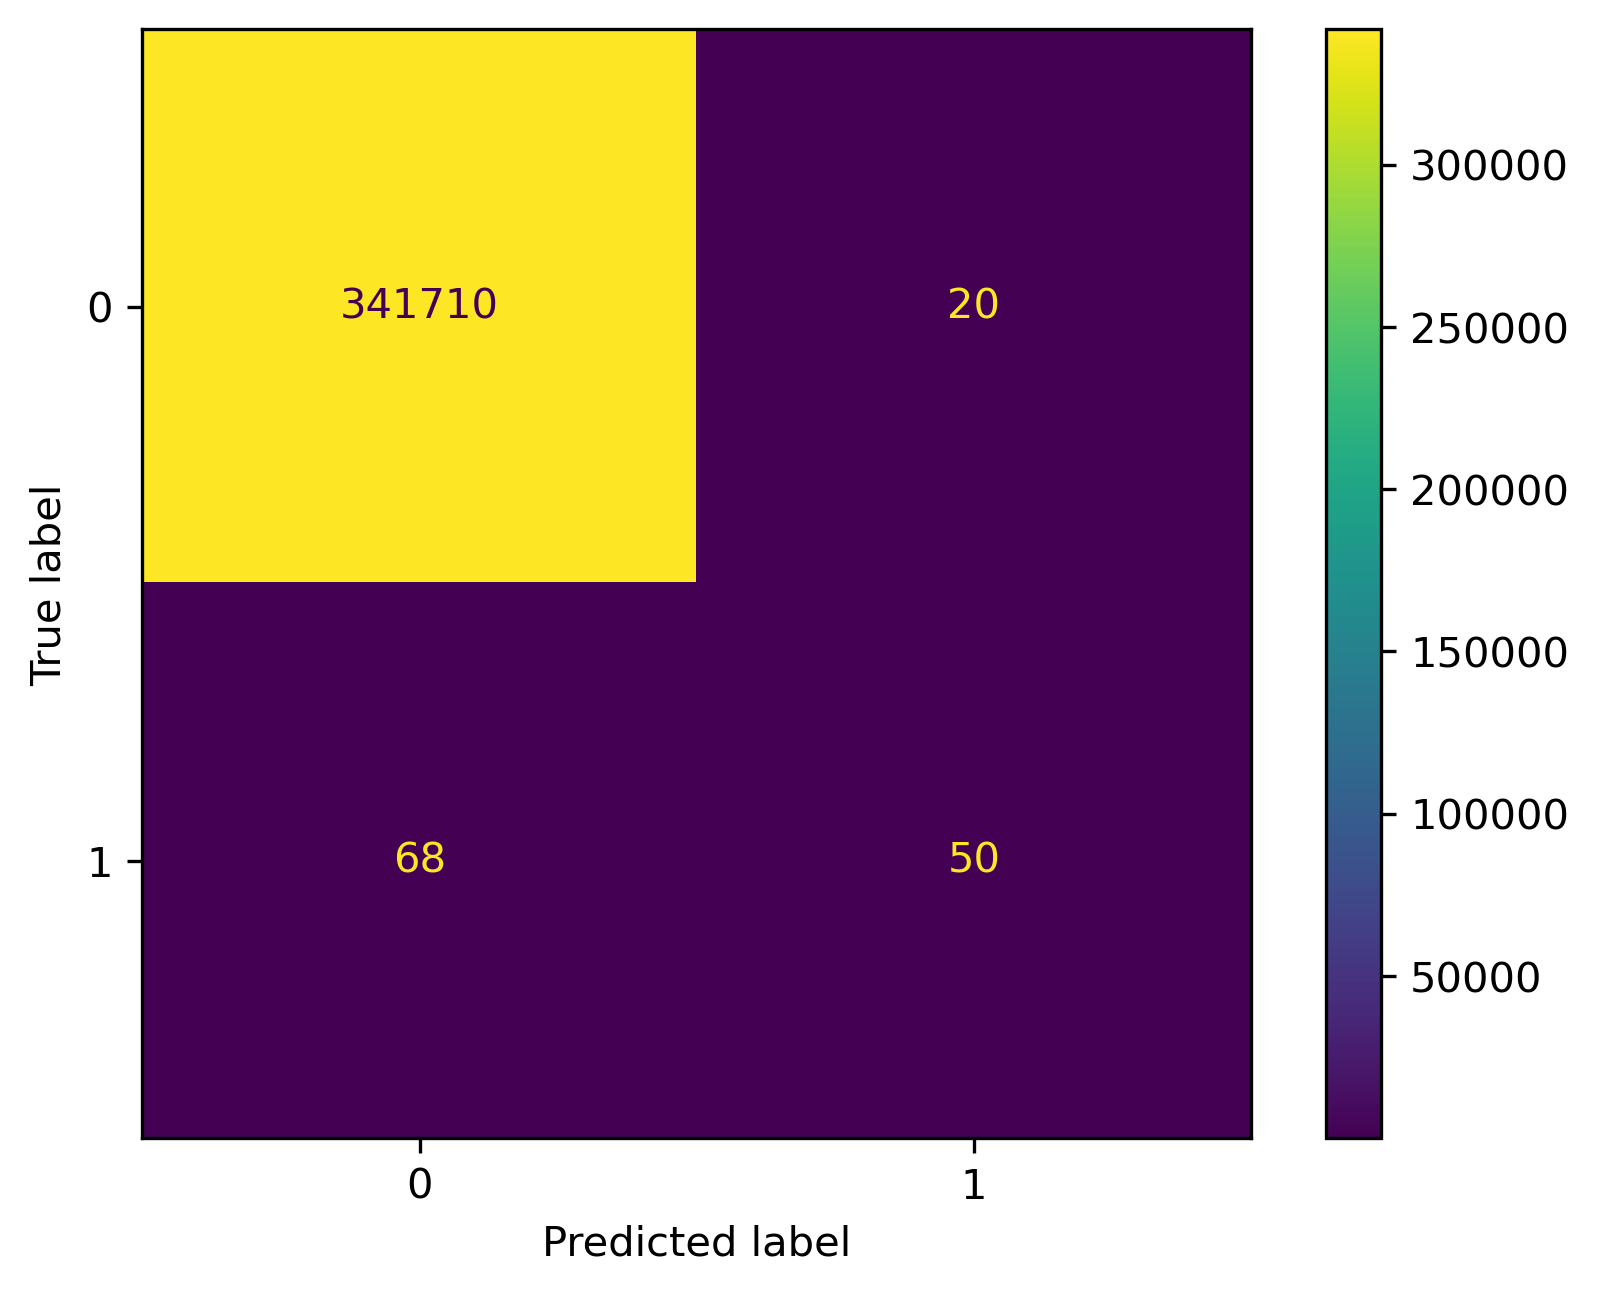

In [3]:
from PIL import Image
Image.open('figures/confusion_matrix_Neuralnet.png')

When the neural network model was applied to 2020 data to make predictions about warehouse locations in 2030, it predicted 96 new warehouses. 

Because the results were not meaningfully different than the random forest model, we decided to continue with the random forests rather than continue trying diffent iterations of neural networks

# Discussion of Results (Alyssa)

## Visualizations to make (Alyssa)

1. 2010 & 2020 Warehouse Locations (maybe over income/race demographics, or CalEnviroscreen?)

2. Using the 'best' model: (likely the random forest  top 20 feature importance one):

        -Predicted 2030 Warehouse Locations 

        -Places that are above a 25% or 50% chance 2030 Warehouse Locations

        -layer with CalEnviroscreen index (already read this in for lecture/class, alternatively could use demographics we have in census data)


